In [ ]:
!pip install xgboost
!brew install libomp
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import precision_recall_fscore_support
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split


# Download dataset
path = kagglehub.dataset_download("uciml/default-of-credit-card-clients-dataset")

/Users/popthrop/Desktop/DS 340/Final Project/DS340/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# CSV file in the downloaded directory
for file in os.listdir(path):
    if file.endswith(".csv"):
        csv_file = os.path.join(path, file)
        break

df = pd.read_csv(csv_file)

target_vec = df['default.payment.next.month']
feature_vec = df.drop('default.payment.next.month', axis=1)

In [ ]:
def evaluate_model(model,x_train,y_train,x_test,y_test):
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    #Evaluations of all models will be based on AUC Score, Precision, Recall, and F score

    precision, recall, fscore, _ = precision_recall_fscore_support(y_test,y_pred)

    print(f'AUC Score: {model.score(x_test,y_test)} \nPrecision: {precision} \nRecall: {recall} \n \
    F Score: {fscore}')

def evaluate_features(model,x_test,y_test,title):
    from sklearn.inspection import permutation_importance

    result = permutation_importance(model, x_test, y_test, n_repeats=15)
    importances = result.importances_mean
    feature_names = feature_vec.columns

    sorted = np.argsort(importances)[::-1] 

    sorted_features = feature_names[sorted]
    sorted_importances = importances[sorted]

    plt.figure(figsize=(10, 6))
    plt.bar(sorted_features, sorted_importances)
    plt.xticks(rotation=90)
    plt.ylabel("Permutation Importance")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(feature_vec, target_vec, train_size=0.8 \
                                                    ,random_state=10)

Baseline Model of Logistic Regression with Cross Validation

AUC Score: 0.7204236846922527 
Precision: [0.87108753 0.37264574] 
Recall: [0.70125988 0.6309795 ] 
     F Score: [0.77700225 0.46856498]


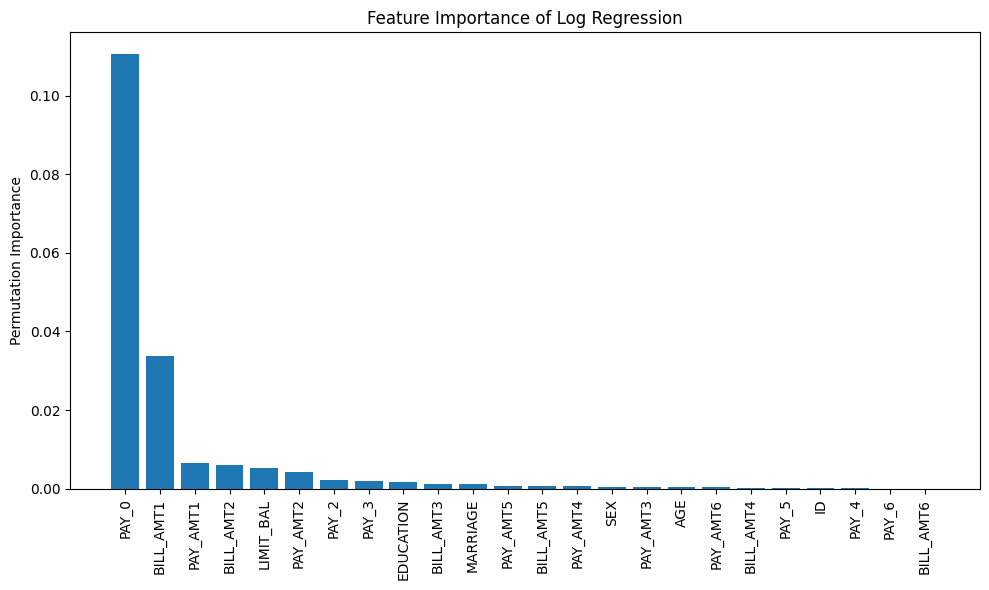

In [21]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

LR_base = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegressionCV(
        cv=5,
        scoring='roc_auc',
        max_iter=5000,
        class_weight='balanced',
        solver="lbfgs",
        n_jobs=-1

    ))
])

title = 'Feature Importance of Log Regression'
evaluate_model(LR_base,x_train,y_train,x_test,y_test)
evaluate_features(LR_base,x_test,y_test,title)

Start to code more advanced ML techniques 

AUC Score: 0.7770704421929688 
Precision: [0.84406458 0.67482993] 
Recall: [0.94896434 0.37661352] 
     F Score: [0.89344592 0.4834308 ]


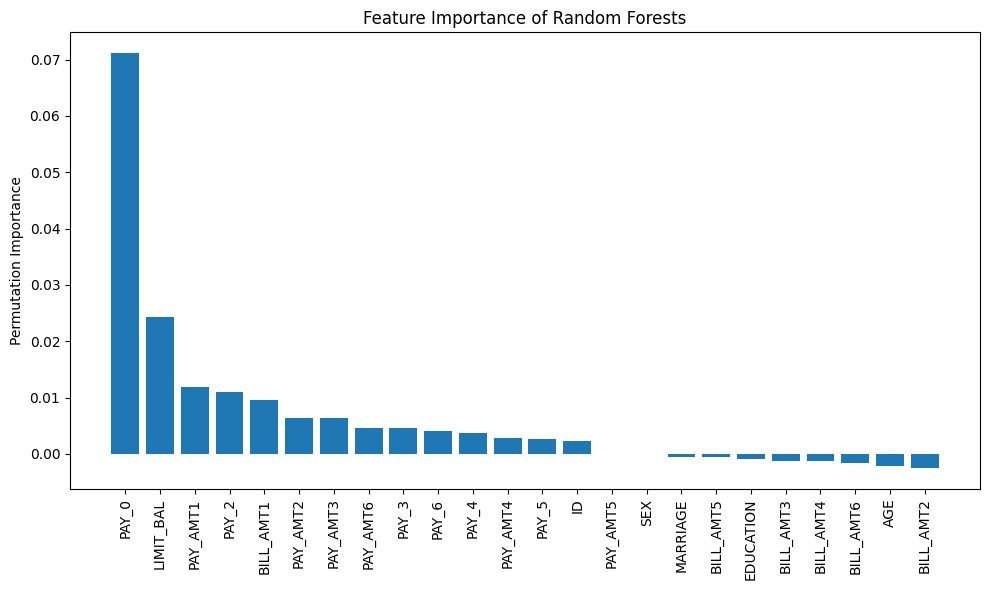

In [ ]:
#Random Forests
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

parameter_grid = {'n_estimators': [10,100,200,500,1000]}

RF = RandomForestClassifier()
RF_gridsearch = GridSearchCV(RF,param_grid=parameter_grid,scoring='roc_auc',cv=7,n_jobs=-1)

title = 'Feature Importance of Random Forests'
evaluate_model(RF_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(RF_gridsearch,x_test,y_test,title)

AUC Score: 0.7886007823901733 
Precision: [0.84099869 0.69836553] 
Recall: [0.95665172 0.35687168] 
     F Score: [0.8951049  0.47236181]


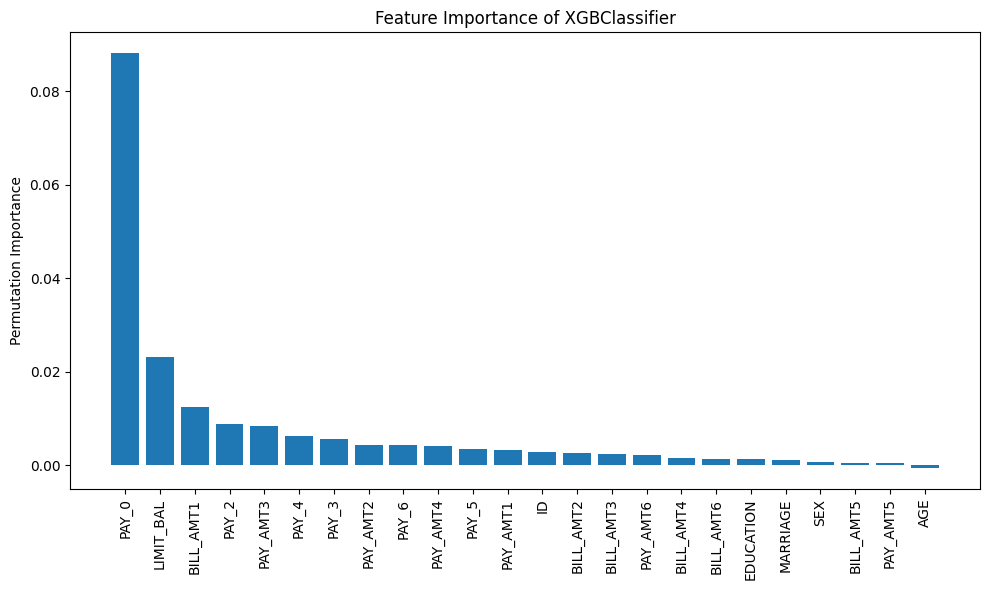

In [28]:
from xgboost import XGBClassifier

paramater_grid = {'n_estimators': [10,100,200,500,1000],'max_depth': [3,4,5,6,7], 'learning_rate': [0.01,0.05,0.1]}
xgb = XGBClassifier()
xgb_gridsearch = GridSearchCV(xgb,param_grid=parameter_grid,scoring='roc_auc',cv=7,n_jobs=-1)

title = 'Feature Importance of XGBClassifier'
evaluate_model(xgb_gridsearch,x_train,y_train,x_test,y_test)
evaluate_features(xgb_gridsearch,x_test,y_test,title)